In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 21:39:37 2023

@author: Bebesi Laci
"""

import sys
import os
import re
import pandas as pd
import numpy as np
import yfinance as yf
import logging
import sqlite3
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")
from factor_model.model_update.loaders.crypto_coin_loaders import get_extended_ticker_list
from factor_model.model_update.loaders.price_data_loaders import (
    generate_ytickets,
    generate_price_data_map,
)
from factor_model.model_update.loaders.market_cap_loader import (
    generate_market_cap_data,
    generate_market_cap_only,
)
from factor_model.model_update.loaders.crypto_coin_loaders import get_ticker_list, get_extended_ticker_list
from statsmodels.stats.outliers_influence import variance_inflation_factor

from factor_model.model_update.return_generators.total_return_calculation import (
    generate_return_data,
)
from datetime import date, timedelta
from factor_model.model_update.database_generators.generate_databases import (
    refresh_database,
)
from factor_model.model_update.estimation_universe.estimation_core_universe import (
    generate_estimation_basis,
)
from factor_model.model_update.styles.return_based import (
    generate_x_month_price_change,
)
from factor_model.model_update.styles.volume_based import (
    generate_x_month_aggregate_volume,
)
from factor_model.model_update.factor_return_estimation.factor_return_estimation import (
    create_factor_return_data,
)
from factor_model.model_update.loaders.risk_free_rate_loader import get_risk_free_rate_history
from factor_model.model_update.return_generators.excess_return_calculation import generate_excess_returns
# from analysis.tickers import ticker_list
# from analysis.utility import convert_str_numbs_to_float
# from analysis.styles.return_based import generate_x_month_momentum
# from analysis.market_cap import generate_market_cap_data
# from analysis.ticker_basics import generate_ytickets, generate_price_data_map
# from analysis.returns import generate_return_data
# from analysis.estimation_basis import generate_estimation_basis
# from datetime import date, timedelta
# import matplotlib.pyplot as plt
# import datetime
# import statsmodels.api as sm
# from analysis.factor_return_dataset import create_factor_return_data, create_expo_from_daily_data
# from tqdm import tqdm
# import matplotlib.pyplot as plt

DATABASE_LOCATION = r"E:/Thesis/database"
from factor_model.model_update.database_generators import (
    RAW_DATA_DB,
    RETURN_DB,
    FACTOR_MODEL_ESTIMATES
)


In [59]:

parameters = {
    "HORIZON" : "15y",
    "ESTIMATION_HORIZON": int(7.5*365),
    "WEIGHT_FUNCTION" : np.sqrt,
    "PRESENT_IN_MARKET" : 3*365,  # trade days, 3 years approx
    "ESTIMATION_DAY": date.today(),
    "MARKET_CAP_COVERAGE" : 0.90,
    "NEW_COIN_INCLUSION": 120,  # after X days
    "REGRESSORS_SET1": ["market", "size", "momentum", "reversal", "volume", "new_coin"],
    "REGRESSORS_SET2": [],
    "MONTH_LENGTH": 30,
    "GENERATE_DATABASE": True
}
parameters["CORE_UNIV_START"] = parameters["ESTIMATION_DAY"] - timedelta(parameters["PRESENT_IN_MARKET"])


##### 1. Grab the list of tickers

In [28]:
tickers = get_extended_ticker_list(1000)  # the number of crypto can be adjusted...
# TODO : survival bias should be fixed by adding discontiued crypto currency
print([f for f in tickers if not f.endswith("USD")])


[]


##### 2. Load Crypto Historical data

In [29]:
yfinance_tickers = generate_ytickets(tickers)
price_data_map, tickers_with_missing_data = generate_price_data_map(yfinance_tickers, parameters["HORIZON"])

if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data=price_data_map,
        database_location=DATABASE_LOCATION,
        database_name=RAW_DATA_DB,
        database_table_name="raw_price_data",
    )

# refresh tickers and throw out those ones, which have no price history
drop_keys = list()
for key in price_data_map.keys():
    if len(price_data_map[key]) < 2:  # minimum number of obs for returns are 2
        del yfinance_tickers[key]
        drop_keys.append(key)
for key in drop_keys:
    del price_data_map[key]


##### 3. Get market capitalization

In [30]:
# market_cap_df = generate_market_cap_data(yfinance_tickers)
market_cap_df = generate_market_cap_only(yfinance_tickers)
# generate square root of cap weighting
market_cap_df["transformed_market_cap"] = parameters["WEIGHT_FUNCTION"](market_cap_df["market_cap"])
market_cap_df.sort_values(by = "transformed_market_cap", ascending=False, inplace=True)


##### 4. Calculate total and excess returns + align estimation dates

In [31]:
total_return_data_map = generate_return_data(price_data_map)


E:\Thesis/crypto_project\factor_model\model_update\return_generators\total_return_calculation.py:9: RuntimeWarning: divide by zero encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(
E:\Thesis/crypto_project\factor_model\model_update\return_generators\total_return_calculation.py:9: RuntimeWarning: invalid value encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(


In [32]:
estimation_dates=list(total_return_data_map["BTC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"])
estimation_dates = list(
    total_return_data_map["ETC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"]
)
estimation_dates = [
    date_value
    for date_value in estimation_dates
    if date_value > datetime.date(2018, 5, 8)
]  # six months after ETH-USD has data in yfinance


In [36]:
# risk free rates and excess returns
risk_free_rate_data = get_risk_free_rate_history(estimation_dates)
excess_return_data_map = generate_excess_returns(
    total_return_data_map, risk_free_rate_data
)
if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data=excess_return_data_map,
        database_location=DATABASE_LOCATION,
        database_name=RETURN_DB,
        database_table_name="returns",
        delete_database=True
    )
    refresh_database(
        symbol_level_data={"SOFR/Treasury-3M": risk_free_rate_data},
        database_location=DATABASE_LOCATION,
        database_name=RETURN_DB,
        database_table_name="risk_free_rates",
        delete_database=False
    )

[*********************100%%**********************]  1 of 1 completed
2024-03-06 20:13:16,544 - INFO - First SOFR date is 2018-04-30 00:00:00, before this date, the 3M US Treasury rate is used as risk free rate.
2024-03-06 20:13:16,544 - INFO - 3M US Treasury rate is used for 3348 trading days.


##### 5. Style generation

In [39]:
momentum_move_map = generate_x_month_price_change(price_data_map,  x_len = 6, month_len = parameters["MONTH_LENGTH"])
reversal_map = generate_x_month_price_change(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
volume_map = generate_x_month_aggregate_volume(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
daily_data_maps = {}
daily_data_maps["reversal"] = reversal_map
daily_data_maps["momentum"] = momentum_move_map
daily_data_maps["return"] = excess_return_data_map
daily_data_maps["volume"] = volume_map


In [80]:
tstats_all = list()
coefficients_all = list()
vif_all = list()
model_summary = list()
try:
    os.remove(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES))
except Exception:
    pass

for date in tqdm(estimation_dates):
    # step 0 : assemble and save estimation data
    estimation_basis, _ = generate_estimation_basis(
        excess_return_data_map, market_cap_df, date, parameters
    )
    factor_return_data = create_factor_return_data(
        estimation_basis, parameters, date, daily_data_maps
    )
    factor_return_data_core = factor_return_data[
        factor_return_data["core_universe"] > 0
    ]
    if parameters["GENERATE_DATABASE"]:
        refresh_database(
            symbol_level_data={str(date): factor_return_data},
            database_location=DATABASE_LOCATION,
            database_name=FACTOR_MODEL_ESTIMATES,
            database_table_name="exposures",
            delete_database=False,
            key_field_name="date",
            update_mode="append",
        )
    # step 1 estimation
    try:
        mod_wls = sm.WLS(
            endog=factor_return_data_core["return"],
            exog=factor_return_data_core[parameters["REGRESSORS_SET1"]],
            weights=factor_return_data_core["transformed_market_cap"],
        ).fit()

        # step 2 save results
        coefficient_date = mod_wls.params.to_frame().T
        coefficient_date["date"] = date
        coefficients_all.append(coefficient_date)

        tstat_date = mod_wls.tvalues.to_frame().T
        tstat_date["date"] = date
        tstats_all.append(tstat_date)

        model_summary.append(
            pd.DataFrame(
                {
                    "r2_core": [mod_wls.rsquared],
                    "r2_adj": [mod_wls.rsquared_adj],
                    "nobs": [mod_wls.nobs],
                }
            )
        )

        exog = factor_return_data[
            parameters["REGRESSORS_SET1"] + parameters["REGRESSORS_SET2"]
        ].to_numpy()
        num_features = exog.shape[1]
        vif_values = [variance_inflation_factor(exog, i) for i in range(num_features)]
        vif_result_date = (
            pd.Series(
                vif_values,
                index=parameters["REGRESSORS_SET1"] + parameters["REGRESSORS_SET2"],
            )
            .to_frame()
            .T
        )
        vif_result_date["date"] = date
        vif_all.append(vif_result_date)

        specific_returns = factor_return_data[["ticker"]].copy()
        specific_returns["specific_return"] = factor_return_data["return"]-mod_wls.predict(factor_return_data[parameters["REGRESSORS_SET1"]])
        if parameters["GENERATE_DATABASE"]:
            refresh_database(
                symbol_level_data={str(date): specific_returns},
                database_location=DATABASE_LOCATION,
                database_name=FACTOR_MODEL_ESTIMATES,
                database_table_name="specific_returns",
                delete_database=False,
                key_field_name="date",
                update_mode="append",
            )
    except Exception:
        print(date)

  0%|          | 0/2129 [00:00<?, ?it/s]

100%|██████████| 2129/2129 [2:28:35<00:00,  4.19s/it]  


In [81]:
all_tstat = pd.concat(tstats_all, axis = 0)
all_coeff = pd.concat(coefficients_all, axis = 0)
all_vif = pd.concat(vif_all, axis = 0)
all_model_summary = pd.concat(model_summary, axis = 0)
if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_tstat},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="t_statistics",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_coeff},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="factor_returns",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_vif},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="vifs",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_model_summary},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="r_squares",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
    )

##### 6. Analysis and sanity checks

In [82]:
print("Active T-stat ratios")
for style in parameters['REGRESSORS_SET1']:
    active_stat = sum(abs(all_tstat[style])>2)/len(all_tstat)
    active_stat = np.round(active_stat,3)
    print(f" {style} : {active_stat}.")
    
for style in parameters['REGRESSORS_SET1']:
    all_coeff[style+"_cumprod"] = (all_coeff[style] +1 ).cumprod()
    
print("Problematic VIF ratios (VIF higher than 5)")
for style in parameters['REGRESSORS_SET1']:
    problematic_vif = sum(abs(all_vif[style])>2)/len(all_vif)
    problematic_vif = np.round(problematic_vif,3)
    print(f" {style} : {problematic_vif}.")

Active T-stat ratios
 market : 0.834.
 size : 0.232.
 momentum : 0.291.
 reversal : 0.42.
 volume : 0.262.
 new_coin : 0.198.
Problematic VIF ratios (VIF higher than 5)
 market : 1.0.
 size : 0.0.
 momentum : 0.025.
 reversal : 0.025.
 volume : 0.0.
 new_coin : 0.0.


In [89]:
all_tstat2 = all_tstat.copy()
for style in parameters['REGRESSORS_SET1']:
    all_tstat2[style] = abs(all_tstat2[style])
all_tstat2.describe()

,market,size,momentum,reversal,volume,new_coin
count,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000,2129.000000
mean,8.832707,1.330905,1.586155,2.208161,1.486189,1.232825
std,8.071797,1.138607,1.359166,2.154101,1.246755,1.007018
min,0.006292,0.000739,0.001412,0.000908,0.000250,0.002426
25%,2.920462,0.471569,0.574484,0.802977,0.550515,0.458786
50%,6.660430,1.071564,1.250732,1.639326,1.177643,1.012775
75%,12.116576,1.906647,2.193605,2.895006,2.075167,1.741396
max,53.796039,7.376088,10.162642,20.690723,7.700813,6.918796


In [83]:
all_model_summary.describe()

,r2_core,r2_adj,nobs
count,2129.000000,2129.000000,2129.000000
mean,0.106485,0.080496,296.945045
std,0.103317,0.098739,188.414153
min,0.000651,-0.053653,46.000000
25%,0.035843,0.016200,123.000000
50%,0.072307,0.047348,251.000000
75%,0.139595,0.109634,494.000000
max,0.661093,0.651086,628.000000


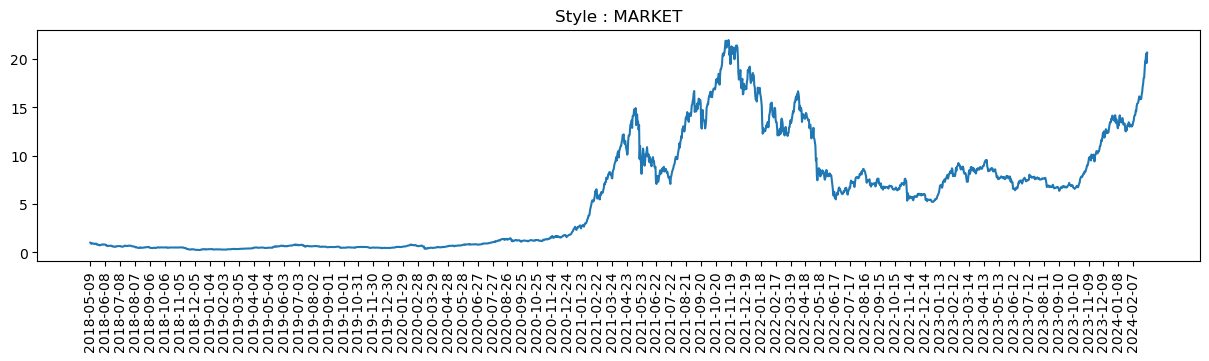

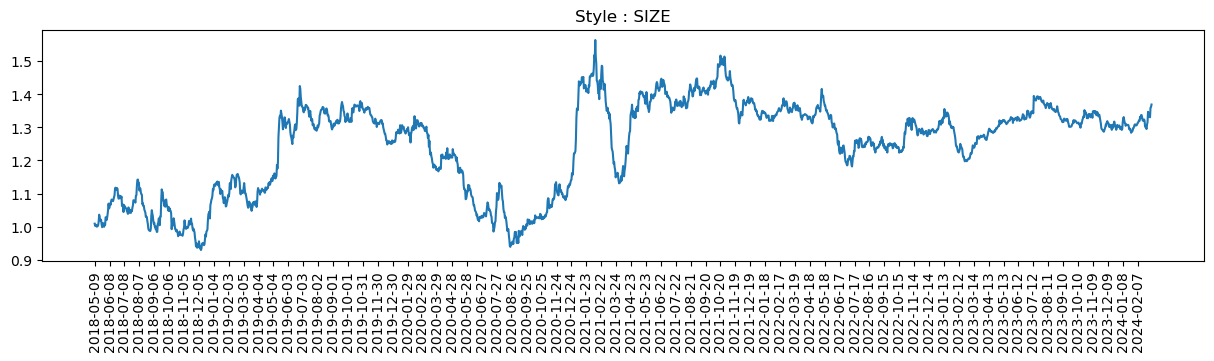

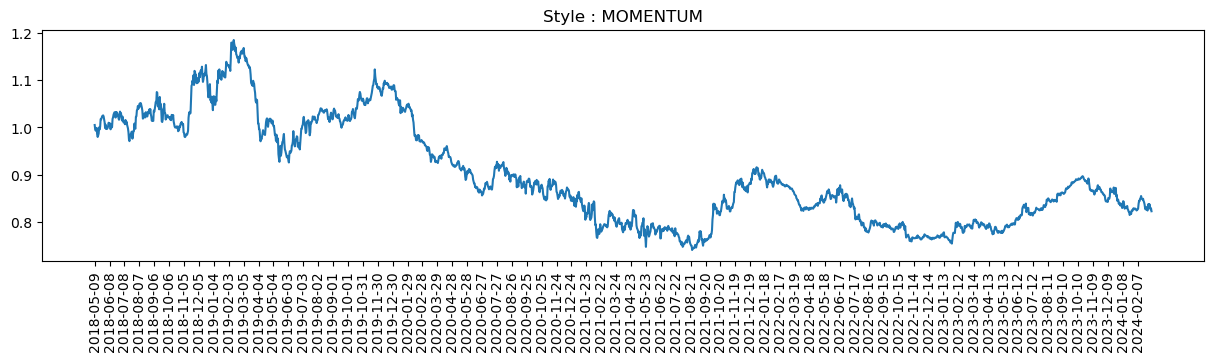

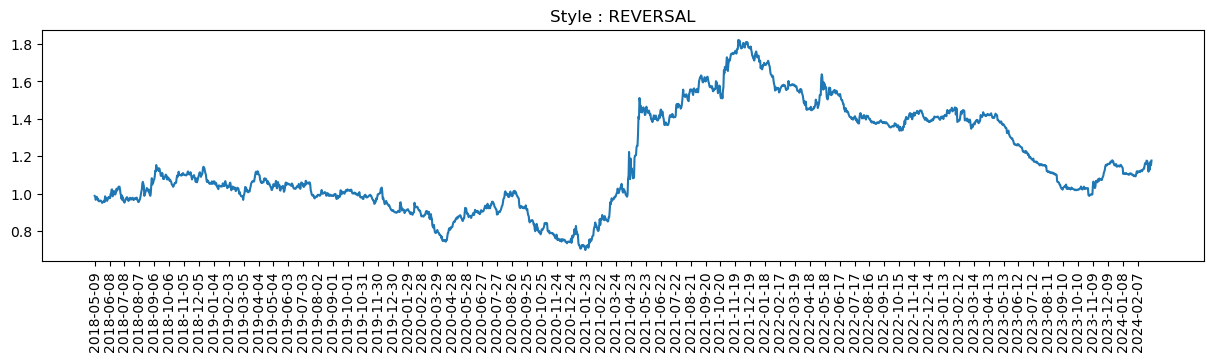

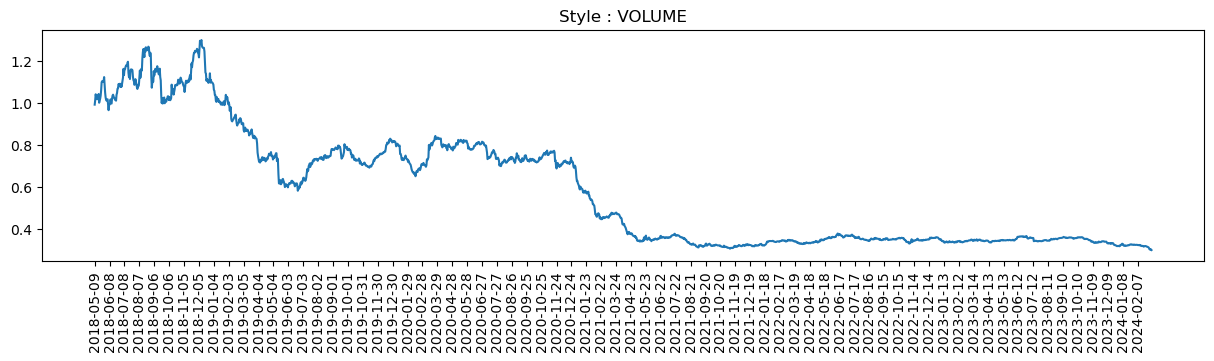

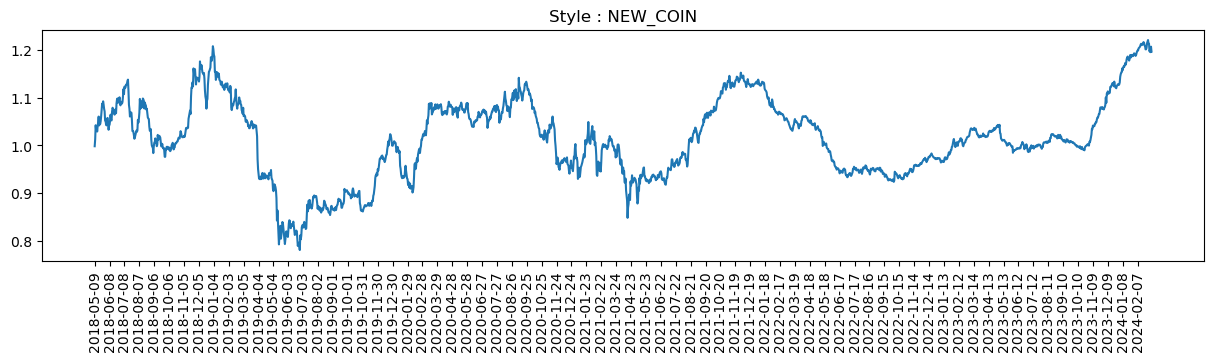

In [84]:
for style in parameters['REGRESSORS_SET1']:
    plt.figure(figsize=(15,3))
    plt.plot(range(0, len(all_coeff)),all_coeff[style+"_cumprod"])
    plt.title(f"Style : {style.upper()}")
    plt.xticks(range(0,len(all_coeff),30), list(all_coeff["date"])[::30], rotation = 90)
    plt.savefig(f"E:\Thesis\stuff\{style}.png")
    plt.show()

In [85]:
all_coeff[parameters['REGRESSORS_SET1']].corr()

,market,size,momentum,reversal,volume,new_coin
market,1.000000,0.295700,0.012066,-0.040694,-0.699891,-0.319952
size,0.295700,1.000000,-0.084467,0.016170,-0.610790,-0.036941
momentum,0.012066,-0.084467,1.000000,-0.259367,0.065023,0.095445
reversal,-0.040694,0.016170,-0.259367,1.000000,0.022228,0.083474
volume,-0.699891,-0.610790,0.065023,0.022228,1.000000,0.493754
new_coin,-0.319952,-0.036941,0.095445,0.083474,0.493754,1.000000


In [91]:
# with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
#     df = pd.read_sql_query("SELECT * FROM vifs", conn)
# display(df)